### Medicare Provider Utilization and Payment Data


The Center for Medicare and Medicaid Services (CMS) has created a dataset with information on services and procedures provided to Medicare patients by physicians and other healthcare professionals. The dataset provides information on utilization (type of service provided), payments (both the total allowed amount and the amount Medicare actually paid), and submitted charges. The data is sorted by location of provider and various descriptors of their patients, including their age, ethnicity, and the percentages of patients suffering from various chronic illnesses. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 5] 
import pdb
import warnings
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import Lasso
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')
from scipy import stats

In [2]:
df = pd.read_csv('https://tufts.box.com/shared/static/eu8kpn2wetgpk0tgsnxtnbiv56adioem.csv')

/Users/kushantsunkara/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


My dataset had over a million rows and 75 different columns. I had to upload the CSV dataset onto box and pull the set from the cloud. 

In [3]:
df.head(15)

,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,...,Percent (%) of Beneficiaries Identified With Depression,Percent (%) of Beneficiaries Identified With Diabetes,Percent (%) of Beneficiaries Identified With Hyperlipidemia,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis,Percent (%) of Beneficiaries Identified With Schizophrenia / Other Psychotic Disorders,Percent (%) of Beneficiaries Identified With Stroke,Average HCC Risk Score of Beneficiaries
0,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,42.0,53.0,67.0,75.0,53.0,12.0,49.0,9.0,13.0,2.0239
1,1003000134,CIBULL,THOMAS,L,M.D.,M,I,2650 RIDGE AVE,EVANSTON HOSPITAL,EVANSTON,...,13.0,21.0,46.0,54.0,26.0,9.0,38.0,1.0,3.0,1.0925
2,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,50.0,37.0,53.0,73.0,37.0,8.0,75.0,6.0,5.0,1.5809
3,1003000407,GIRARDI,DAVID,J,D.O.,M,I,100 HOSPITAL RD,NaN,BROOKVILLE,...,47.0,40.0,69.0,75.0,64.0,15.0,43.0,12.0,14.0,2.0000
4,1003000423,VELOTTA,JENNIFER,A,M.D.,F,I,11100 EUCLID AVE,NaN,CLEVELAND,...,28.0,27.0,41.0,52.0,21.0,NaN,46.0,NaN,0.0,0.9540
5,1003000480,ROTHCHILD,KEVIN,B,MD,M,I,12605 E 16TH AVE,NaN,AURORA,...,41.0,39.0,35.0,64.0,34.0,14.0,56.0,NaN,NaN,1.6955
6,1003000522,WEIGAND,FREDERICK,J,MD,M,I,1565 SAXON BLVD,SUITE 102,DELTONA,...,16.0,32.0,75.0,75.0,38.0,11.0,54.0,NaN,6.0,1.2619
7,1003000530,SEMONCHE,AMANDA,M,DO,F,I,1021 PARK AVE,SUITE 203,QUAKERTOWN,...,25.0,26.0,62.0,67.0,29.0,5.0,27.0,3.0,NaN,1.0124
8,1003000597,KIM,DAE,Y,"M.D., PH.D",M,I,1145 S UTICA AVE,SUITE 202,TULSA,...,30.0,37.0,57.0,75.0,44.0,6.0,47.0,4.0,8.0,1.7237
9,1003000639,BENHARASH,PEYMAN,NaN,MD,M,I,UCLA CARDIOTHORACIC SURGERY 10833 LECONTE AVE,62-182 CHS,LOS ANGELES,...,31.0,51.0,75.0,75.0,75.0,NaN,37.0,NaN,NaN,2.6818


I sampled 15 rows of the data too see what it would look like in the notebook and what variables were available to me to analyze and clean.

In [4]:
df.columns

Index(['National Provider Identifier',
       'Last Name/Organization Name of the Provider',
       'First Name of the Provider', 'Middle Initial of the Provider',
       'Credentials of the Provider', 'Gender of the Provider',
       'Entity Type of the Provider', 'Street Address 1 of the Provider',
       'Street Address 2 of the Provider', 'City of the Provider',
       'Zip Code of the Provider', 'State Code of the Provider',
       'Country Code of the Provider', 'Provider Type of the Provider',
       'Medicare Participation Indicator', 'Number of HCPCS',
       'Number of Services', 'Number of Medicare Beneficiaries',
       'Total Submitted Charge Amount', 'Total Medicare Allowed Amount',
       'Total Medicare Payment Amount',
       'Total Medicare Standardized Payment Amount', 'Drug Suppress Indicator',
       'Number of HCPCS Associated With Drug Services',
       'Number of Drug Services',
       'Number of Medicare Beneficiaries With Drug Services',
       'Total Drug Sub

In [5]:
df.isnull().sum()

National Provider Identifier                                                                   0
Last Name/Organization Name of the Provider                                                   20
First Name of the Provider                                                                 62608
Middle Initial of the Provider                                                            336578
Credentials of the Provider                                                               103570
Gender of the Provider                                                                     62596
Entity Type of the Provider                                                                    0
Street Address 1 of the Provider                                                               1
Street Address 2 of the Provider                                                          639478
City of the Provider                                                                           1
Zip Code of the Provider      

Because of the vast amount of columns, I was not able to see all of the different variables in the sample set. I indexed the variables to see which ones I actually wanted to work with and which I thought were irrelevant to my analysis. 

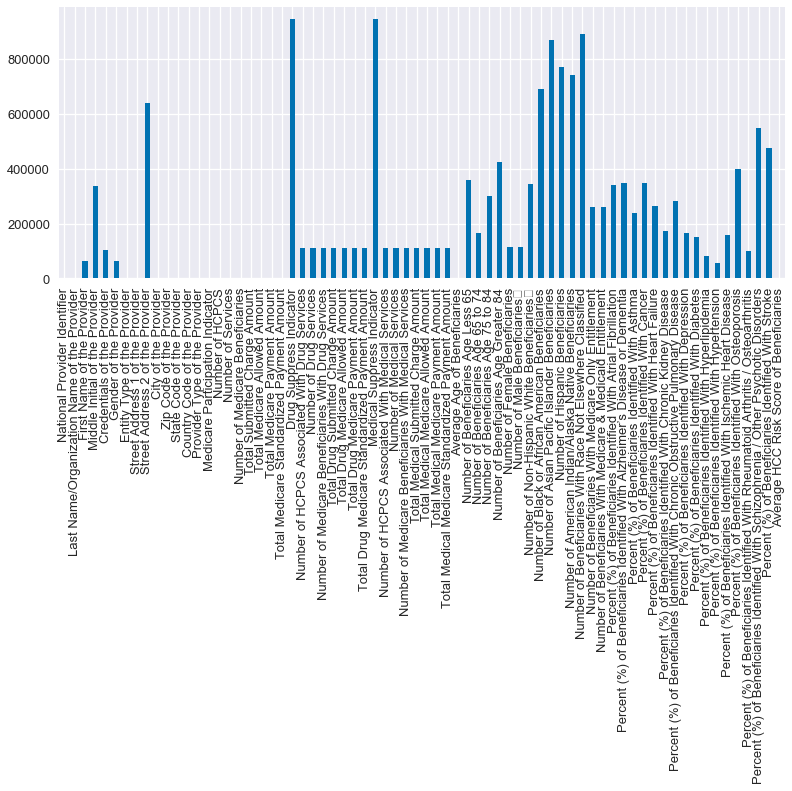

In [6]:
df.isnull().sum().plot(kind='bar')
plt.show()

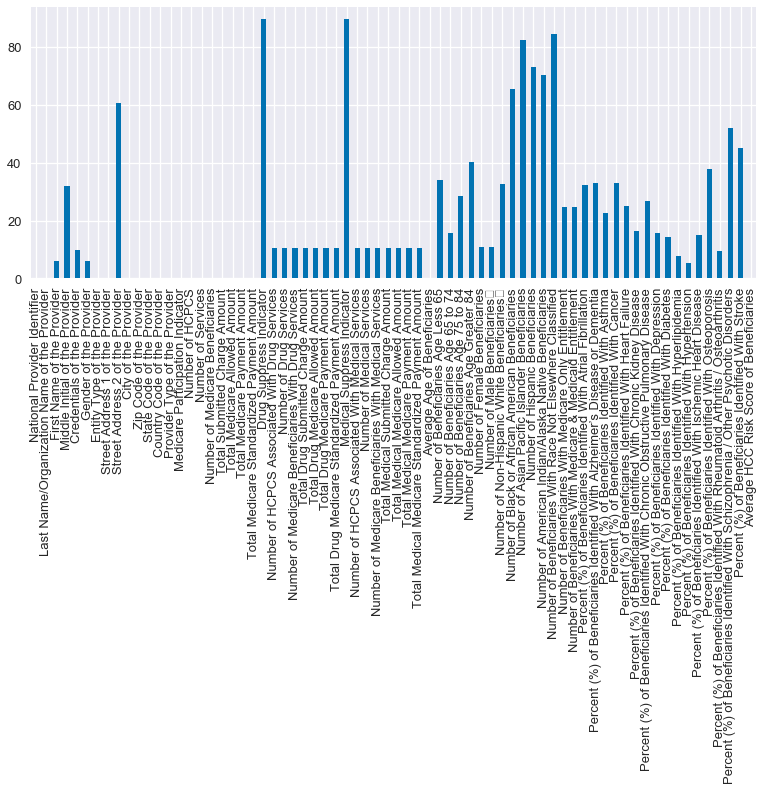

Text(0.5,1,'Percent Missing by Variable')

In [7]:
(df.isnull().sum()/(len(df))*100).plot(kind='bar')
plt.show()
plt.title('Percent Missing by Variable')

In the above charts, I decided to figure out which variables had the most amount of missing datapoints. I first created a bar graph of how many cells were missing for each variables. Then, I graphed them out by percentage of the total amount of rows.

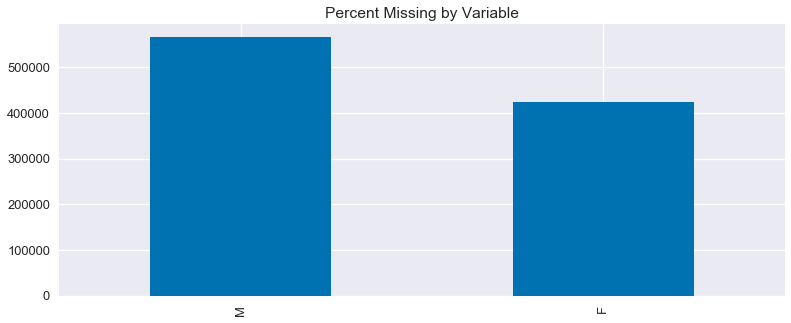

Text(0.5,1,'Gender of Provider')

In [8]:
df['Gender of the Provider'].value_counts().plot(kind='bar')
plt.show()
plt.title('Gender of Provider')

This is a simple analysis of the breakdown of the gender of all of the providers shown in the data. 

In [9]:
meddata=df.drop(labels=['Middle Initial of the Provider','Street Address 1 of the Provider', 'Street Address 2 of the Provider','Zip Code of the Provider','Country Code of the Provider','Medicare Participation Indicator','Total Medicare Standardized Payment Amount','Drug Suppress Indicator','Number of HCPCS Associated With Drug Services','Total Drug Medicare Standardized Payment Amount','Medical Suppress Indicator','Total Medical Medicare Standardized Payment Amount','Number of Non-Hispanic White Beneficiaries\t','Number of Black or African American Beneficiaries','Number of Asian Pacific Islander Beneficiaries','Number of Hispanic Beneficiaries','Number of American Indian/Alaska Native Beneficiaries','Number of Beneficiaries With Race Not Elsewhere Classified','Average HCC Risk Score of Beneficiaries','National Provider Identifier','First Name of the Provider','Percent (%) of Beneficiaries Identified With Depression','Percent (%) of Beneficiaries Identified With Hyperlipidemia','Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis','Percent (%) of Beneficiaries Identified With Schizophrenia / Other Psychotic Disorders','Number of HCPCS Associated With Medical Services'], axis=1)
                
                

In [10]:
meddata.columns

Index(['Last Name/Organization Name of the Provider',
       'Credentials of the Provider', 'Gender of the Provider',
       'Entity Type of the Provider', 'City of the Provider',
       'State Code of the Provider', 'Provider Type of the Provider',
       'Number of HCPCS', 'Number of Services',
       'Number of Medicare Beneficiaries', 'Total Submitted Charge Amount',
       'Total Medicare Allowed Amount', 'Total Medicare Payment Amount',
       'Number of Drug Services',
       'Number of Medicare Beneficiaries With Drug Services',
       'Total Drug Submitted Charge Amount',
       'Total Drug Medicare Allowed Amount',
       'Total Drug Medicare Payment Amount', 'Number of Medical Services',
       'Number of Medicare Beneficiaries With Medical Services',
       'Total Medical Submitted Charge Amount',
       'Total Medical Medicare Allowed Amount',
       'Total Medical Medicare Payment Amount', 'Average Age of Beneficiaries',
       'Number of Beneficiaries Age Less 65',
     

I dropped many of the variables that had many missing cells and also dropped columns that I did not think would be relevant to my analysis. I then indexed the columns again to see what I would be working with. 

In [11]:
meddata.head()

,Last Name/Organization Name of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,City of the Provider,State Code of the Provider,Provider Type of the Provider,Number of HCPCS,Number of Services,Number of Medicare Beneficiaries,...,Percent (%) of Beneficiaries Identified With Asthma,Percent (%) of Beneficiaries Identified With Cancer,Percent (%) of Beneficiaries Identified With Heart Failure,Percent (%) of Beneficiaries Identified With Chronic Kidney Disease,Percent (%) of Beneficiaries Identified With Chronic Obstructive Pulmonary Disease,Percent (%) of Beneficiaries Identified With Diabetes,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Stroke
0,ENKESHAFI,M.D.,M,I,CUMBERLAND,MD,Internal Medicine,23,1477.0,518,...,42.0,15.0,42.0,63.0,39.0,53.0,75.0,53.0,12.0,13.0
1,CIBULL,M.D.,M,I,EVANSTON,IL,Pathology,18,8704.0,4003,...,9.0,13.0,12.0,19.0,8.0,21.0,54.0,26.0,9.0,3.0
2,KHALIL,M.D.,M,I,TOLEDO,OH,Anesthesiology,43,1608.0,208,...,34.0,5.0,23.0,29.0,30.0,37.0,73.0,37.0,8.0,5.0
3,GIRARDI,D.O.,M,I,BROOKVILLE,PA,Family Practice,31,1637.0,401,...,49.0,15.0,40.0,54.0,48.0,40.0,75.0,64.0,15.0,14.0
4,VELOTTA,M.D.,F,I,CLEVELAND,OH,Obstetrics & Gynecology,26,163.0,82,...,15.0,NaN,NaN,NaN,13.0,27.0,52.0,21.0,NaN,0.0


In [12]:
columns1 = ['Number of Services','Total Submitted Charge Amount','Total Medicare Allowed Amount','Total Medicare Payment Amount','Number of Beneficiaries Age Less 65','Number of Beneficiaries Age 65 to 74','Number of Beneficiaries Age 75 to 84','Number of Beneficiaries Age Greater 84']
meddata_age = pd.DataFrame(meddata, columns=columns1)

In [13]:
corr2 = meddata_age.corr()

In [14]:
corr2df = pd.DataFrame(corr2)
corr2df.head(4)

,Number of Services,Total Submitted Charge Amount,Total Medicare Allowed Amount,Total Medicare Payment Amount,Number of Beneficiaries Age Less 65,Number of Beneficiaries Age 65 to 74,Number of Beneficiaries Age 75 to 84,Number of Beneficiaries Age Greater 84
Number of Services,1.000000,0.781115,0.767866,0.804617,0.792575,0.836959,0.841621,0.758489
Total Submitted Charge Amount,0.781115,1.000000,0.900951,0.917664,0.782068,0.818482,0.824602,0.725631
Total Medicare Allowed Amount,0.767866,0.900951,1.000000,0.993438,0.716747,0.746505,0.778142,0.737287
Total Medicare Payment Amount,0.804617,0.917664,0.993438,1.000000,0.770639,0.802792,0.825444,0.761436


I selected variables that had to do with total medicare charges and the age of the beneficiaries and ran a correlation analysis. I wanted to see if more medicare dollars were spent on older patients. The correlation chart shows that the amount of spending increases up to the age range of 75-84, but then drops for patients older than 84. The reasoning for this is perhaps older patients opt out of invasive or expensive treatments and rather settle for palliative care or symptom management. 

In [15]:
columns2 = ['Number of Services','Total Submitted Charge Amount','Total Medicare Allowed Amount','Total Medicare Payment Amount','Percent (%) of Beneficiaries Identified With Atrial Fibrillation','Percent (%) of Beneficiaries Identified With Alzheimer’s Disease or Dementia','Percent (%) of Beneficiaries Identified With Asthma','Percent (%) of Beneficiaries Identified With Cancer','Percent (%) of Beneficiaries Identified With Heart Failure','Percent (%) of Beneficiaries Identified With Chronic Kidney Disease','Percent (%) of Beneficiaries Identified With Chronic Obstructive Pulmonary Disease','Percent (%) of Beneficiaries Identified With Diabetes','Percent (%) of Beneficiaries Identified With Hypertension','Percent (%) of Beneficiaries Identified With Ischemic Heart Disease','Percent (%) of Beneficiaries Identified With Osteoporosis','Percent (%) of Beneficiaries Identified With Stroke']
meddata_disease = pd.DataFrame(meddata, columns=columns2)


In [16]:
corr3 = meddata_disease.corr()
corr3.style.background_gradient(cmap='coolwarm')

,Number of Services,Total Submitted Charge Amount,Total Medicare Allowed Amount,Total Medicare Payment Amount,Percent (%) of Beneficiaries Identified With Atrial Fibrillation,Percent (%) of Beneficiaries Identified With Alzheimer’s Disease or Dementia,Percent (%) of Beneficiaries Identified With Asthma,Percent (%) of Beneficiaries Identified With Cancer,Percent (%) of Beneficiaries Identified With Heart Failure,Percent (%) of Beneficiaries Identified With Chronic Kidney Disease,Percent (%) of Beneficiaries Identified With Chronic Obstructive Pulmonary Disease,Percent (%) of Beneficiaries Identified With Diabetes,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Stroke
Number of Services,1,0.781115,0.767866,0.804617,-0.00283187,-0.00303134,-0.00788488,0.0501181,-0.00305429,0.00340973,-0.00323922,1.86836e-06,0.0195528,0.00807519,0.0229956,-0.0074269
Total Submitted Charge Amount,0.781115,1,0.900951,0.917664,0.00739045,-0.0156517,-0.00409705,0.0416491,0.00340527,0.00890195,0.000125281,0.0087311,0.0432494,0.0312944,0.00970943,0.000175218
Total Medicare Allowed Amount,0.767866,0.900951,1,0.993438,0.0144199,-0.00788106,-0.0110913,0.0555389,0.00777915,0.0114802,-0.00184348,0.0151614,0.0542622,0.0434912,0.0249158,8.00015e-05
Total Medicare Payment Amount,0.804617,0.917664,0.993438,1,0.0119598,-0.00657281,-0.00916707,0.0496002,0.00705349,0.0105134,-0.00118416,0.0137091,0.0474767,0.0378556,0.022136,-9.03704e-05
Percent (%) of Beneficiaries Identified With Atrial Fibrillation,-0.00283187,0.00739045,0.0144199,0.0119598,1,0.494936,0.538838,0.228613,0.781856,0.636623,0.587679,0.377239,0.466414,0.743966,0.274926,0.539682
Percent (%) of Beneficiaries Identified With Alzheimer’s Disease or Dementia,-0.00303134,-0.0156517,-0.00788106,-0.00657281,0.494936,1,0.496336,0.0502794,0.656536,0.571286,0.538012,0.441298,0.381775,0.526522,0.356664,0.610636
Percent (%) of Beneficiaries Identified With Asthma,-0.00788488,-0.00409705,-0.0110913,-0.00916707,0.538838,0.496336,1,0.148074,0.735959,0.682138,0.95782,0.536869,0.471184,0.652996,0.136656,0.42354
Percent (%) of Beneficiaries Identified With Cancer,0.0501181,0.0416491,0.0555389,0.0496002,0.228613,0.0502794,0.148074,1,0.1324,0.16554,0.193163,0.000449137,0.133772,0.141547,0.18285,0.129935
Percent (%) of Beneficiaries Identified With Heart Failure,-0.00305429,0.00340527,0.00777915,0.00705349,0.781856,0.656536,0.735959,0.1324,1,0.861707,0.770606,0.684228,0.564004,0.861931,0.199568,0.571661
Percent (%) of Beneficiaries Identified With Chronic Kidney Disease,0.00340973,0.00890195,0.0114802,0.0105134,0.636623,0.571286,0.682138,0.16554,0.861707,1,0.700527,0.752772,0.617469,0.776355,0.15746,0.542125


I ran another correlation to analyze the medicare spending amount against the percentage of patients with various diseases. I found that there were strong correlations among related diseases such as asthma and COPD, and ischemic heart disease and hypertension. Stroke and atrial fibrillation also had very strong correlations. This is interesting considering many tech companies are using variables to track this very same thing (Apple with their Apple Watch Heart Study).

In [17]:
df['Credentials of the Provider'].value_counts()

MD                      257404
M.D.                    249022
CRNA                     35259
PA-C                     32110
D.O.                     29807
D.C.                     21589
DO                       21274
O.D.                     18647
NP                       16362
PA                       14916
PT                       14210
DC                       10965
FNP                      10258
DPT                       9923
DPM                       9795
OD                        8550
M.D                       8327
LCSW                      7835
ARNP                      7785
APRN                      6409
PH.D.                     5498
P.T.                      5126
CRNP                      5007
P.A.                      4698
D.P.M.                    4081
PHD                       4004
NP-C                      3729
FNP-C                     3645
CNP                       3399
N.P.                      3144
                         ...  
MS ANP-C  ACNP-BC            1
MD, PHD,

In [18]:
df['Credentials of the Provider'].value_counts()>1

MD                       True
M.D.                     True
CRNA                     True
PA-C                     True
D.O.                     True
D.C.                     True
DO                       True
O.D.                     True
NP                       True
PA                       True
PT                       True
DC                       True
FNP                      True
DPT                      True
DPM                      True
OD                       True
M.D                      True
LCSW                     True
ARNP                     True
APRN                     True
PH.D.                    True
P.T.                     True
CRNP                     True
P.A.                     True
D.P.M.                   True
PHD                      True
NP-C                     True
FNP-C                    True
CNP                      True
N.P.                     True
                        ...  
MS ANP-C  ACNP-BC       False
MD, PHD, FACP           False
R.N., C.R.

In [19]:
#df.loc[:, df['Credentials of the Provider'].value_counts()>1]

In [20]:
mean1=df['Total Drug Submitted Charge Amount'].mean()
std1=df['Total Drug Submitted Charge Amount'].std()
print(mean1)
print(std1)

34298.64290319395
410161.2457137578


In [21]:
mean2=df['Total Submitted Charge Amount'].mean()
std2=df['Total Submitted Charge Amount'].std()
print(mean2)
print(std2)

348457.824719831
2488942.1358216507


In [22]:
mean3=df['Total Medicare Payment Amount'].mean()
std3=df['Total Medicare Payment Amount'].std()
print(mean3)
print(std3)

90918.64095978069
510857.6718236861


In [23]:
mean4=df['Total Drug Medicare Payment Amount'].mean()
std4=df['Total Drug Medicare Payment Amount'].std()
print(mean4)
print(std4)

13040.813254956973
139662.00306268522


In [24]:
variables = ['Total Drug Submitted Charge Amount','Total Submitted Charge Amount','Total Medicare Payment Amount','Total Drug Medicare Payment Amount']
x_pos = np.arange(len(variables))
Cost = ['mean1','mean2','mean3','mean4']
error = ['std1','std2','std3','std4']

I calculated the total mean and SD of medicare submission and payment amounts. 

In [25]:
training_variables = ['Number of Beneficiaries Age Less 65', 'Number of Beneficiaries Age 65 to 74', 'Number of Beneficiaries Age 75 to 84', 'Number of Beneficiaries Age Greater 84']

X_train, X_test, y_train, y_test = train_test_split(meddata[training_variables],
                 meddata['Total Medicare Payment Amount'], test_size=0.1)


In [26]:
meddata.dtypes.isnull()

Last Name/Organization Name of the Provider                                           False
Credentials of the Provider                                                           False
Gender of the Provider                                                                False
Entity Type of the Provider                                                           False
City of the Provider                                                                  False
State Code of the Provider                                                            False
Provider Type of the Provider                                                         False
Number of HCPCS                                                                       False
Number of Services                                                                    False
Number of Medicare Beneficiaries                                                      False
Total Submitted Charge Amount                                                   

In [27]:
meddata.dropna()

,Last Name/Organization Name of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,City of the Provider,State Code of the Provider,Provider Type of the Provider,Number of HCPCS,Number of Services,Number of Medicare Beneficiaries,...,Percent (%) of Beneficiaries Identified With Asthma,Percent (%) of Beneficiaries Identified With Cancer,Percent (%) of Beneficiaries Identified With Heart Failure,Percent (%) of Beneficiaries Identified With Chronic Kidney Disease,Percent (%) of Beneficiaries Identified With Chronic Obstructive Pulmonary Disease,Percent (%) of Beneficiaries Identified With Diabetes,Percent (%) of Beneficiaries Identified With Hypertension,Percent (%) of Beneficiaries Identified With Ischemic Heart Disease,Percent (%) of Beneficiaries Identified With Osteoporosis,Percent (%) of Beneficiaries Identified With Stroke
0,ENKESHAFI,M.D.,M,I,CUMBERLAND,MD,Internal Medicine,23,1477.0,518,...,42.0,15.0,42.0,63.0,39.0,53.0,75.0,53.0,12.0,13.0
1,CIBULL,M.D.,M,I,EVANSTON,IL,Pathology,18,8704.0,4003,...,9.0,13.0,12.0,19.0,8.0,21.0,54.0,26.0,9.0,3.0
3,GIRARDI,D.O.,M,I,BROOKVILLE,PA,Family Practice,31,1637.0,401,...,49.0,15.0,40.0,54.0,48.0,40.0,75.0,64.0,15.0,14.0
6,WEIGAND,MD,M,I,DELTONA,FL,Family Practice,55,1952.0,417,...,22.0,15.0,18.0,31.0,20.0,32.0,75.0,38.0,11.0,6.0
10,GATTON,M.D.,M,I,MOUNT VERNON,OH,Anesthesiology,44,200.0,175,...,32.0,9.0,23.0,39.0,27.0,41.0,75.0,50.0,11.0,9.0
15,STELLINGWORTH,MD,M,I,COLUMBIA,SC,Internal Medicine,68,4670.0,1374,...,33.0,10.0,36.0,47.0,31.0,45.0,75.0,65.0,6.0,12.0
16,NICHOLS,M.D,M,I,LA PALMA,CA,Dermatology,30,9737.0,278,...,21.0,10.0,23.0,29.0,18.0,38.0,64.0,33.0,8.0,5.0
22,STEVENS,M.D.,M,I,EL CENTRO,CA,Anesthesiology,49,15251.0,911,...,22.0,5.0,17.0,29.0,17.0,41.0,70.0,34.0,10.0,5.0
26,TRIVEDI,MD,M,I,SACRAMENTO,CA,Infectious Disease,13,662.0,254,...,39.0,13.0,53.0,72.0,37.0,61.0,75.0,52.0,10.0,17.0
27,JONES,D.O.,F,I,CLEARWATER,FL,Orthopedic Surgery,98,1835.0,217,...,23.0,8.0,24.0,34.0,23.0,35.0,74.0,32.0,11.0,6.0


In [29]:
# rf = RandomForestClassifier()
# param_dist = {"n_estimators": stats.randint(2, 300),
#               "max_features": ['sqrt',  'log2'],
#               "min_samples_split": stats.randint(5, 50),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}
# random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,
#                                    n_iter=20, cv=10, verbose=1, n_jobs=-1)
# random_rf.fit(X_train, y_train)